# **1. Connecting dataset from google drive**

In [21]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **2. Preprocessing**

In [22]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from glob import glob


In [23]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/Copy of Dataset_Fellowship_AAI_Mirpur_Slum.zip"
extract_path = "/content/dataset"

# Extract zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed!")


Extraction completed!


In [24]:
import glob
import os

DATA_DIR = "/content/dataset/Old"

image_paths = sorted(glob.glob(os.path.join(DATA_DIR, "*.jpg")))
mask_paths = sorted(glob.glob(os.path.join(DATA_DIR, "*___fuse.png")))

print("First 5 Image Paths:", image_paths[:5])
print("First 5 Mask Paths:", mask_paths[:5])


First 5 Image Paths: ['/content/dataset/Old/Chandura Bosti-11.jpg', '/content/dataset/Old/Chandura Bosti-12.jpg', '/content/dataset/Old/Chandura Bosti-21.jpg', '/content/dataset/Old/Chandura Bosti-22.jpg', '/content/dataset/Old/Gabtoli Bosti-11.jpg']
First 5 Mask Paths: ['/content/dataset/Old/Chandura Bosti-11.jpg___fuse.png', '/content/dataset/Old/Chandura Bosti-12.jpg___fuse.png', '/content/dataset/Old/Chandura Bosti-21.jpg___fuse.png', '/content/dataset/Old/Chandura Bosti-22.jpg___fuse.png', '/content/dataset/Old/Gabtoli Bosti-11.jpg___fuse.png']


In [25]:
print("Number of Images:", len(image_paths))
print("Number of Masks:", len(mask_paths))

Number of Images: 33
Number of Masks: 30


# **N.B. Here the number of Original and Mask images are not same we can use those unmasked images as our test image for inference**

In [26]:
print(image_paths)
print(mask_paths)

['/content/dataset/Old/Chandura Bosti-11.jpg', '/content/dataset/Old/Chandura Bosti-12.jpg', '/content/dataset/Old/Chandura Bosti-21.jpg', '/content/dataset/Old/Chandura Bosti-22.jpg', '/content/dataset/Old/Gabtoli Bosti-11.jpg', '/content/dataset/Old/Gabtoli Bosti-12.jpg', '/content/dataset/Old/Gabtoli Bosti-21.jpg', '/content/dataset/Old/Gabtoli Bosti-22.jpg', '/content/dataset/Old/Kalshi-11.jpg', '/content/dataset/Old/Kalshi-121.jpg', '/content/dataset/Old/Kalshi-13.jpg', '/content/dataset/Old/Molla Bosti-11.jpg', '/content/dataset/Old/Molla Bosti-12.jpg', '/content/dataset/Old/Molla Bosti-21.jpg', '/content/dataset/Old/Molla Bosti-22.jpg', '/content/dataset/Old/Molla Bosti-31.jpg', '/content/dataset/Old/Molla Bosti-32.jpg', '/content/dataset/Old/Molla Bosti-41.jpg', '/content/dataset/Old/Molla Bosti-42.jpg', '/content/dataset/Old/Narayangonj-Adaamjee-21.jpg', '/content/dataset/Old/Narayangonj-Adaamjee-31.jpg', '/content/dataset/Old/Narayangonj-Adaamjee-32.jpg', '/content/dataset/Ol

In [27]:


# List of image files (without extension for easy comparison)
image_files = [os.path.basename(path) for path in image_paths]
mask_files = [os.path.basename(path).replace("___fuse.png", "") for path in mask_paths]  # Remove mask suffix

# Find images without a corresponding mask
unmasked_images = [img for img in image_files if img not in mask_files]

# Print unmasked images
print("Unmasked Images:")
print(unmasked_images)


Unmasked Images:
['Gabtoli Bosti-12.jpg', 'Gabtoli Bosti-22.jpg', 'Rupnagar Bosti_02.jpg']


In [28]:
#'/content/dataset/Old/Gabtoli Bosti-12.jpg
#'/content/dataset/Old/Gabtoli Bosti-22.jpg'
#/content/dataset/Old/Rupnagar Bosti_02.jpg',
#Removing the unmasked file to test file

import shutil

# Define source file paths
files_to_move = [
    "/content/dataset/Old/Gabtoli Bosti-12.jpg",
    "/content/dataset/Old/Gabtoli Bosti-22.jpg",
    "/content/dataset/Old/Rupnagar Bosti_02.jpg"
]

# Define destination directory
destination = "/content/dataset/No Mask/"   #This will work as test images further


os.makedirs(destination, exist_ok=True)

# Move files
for file in files_to_move:
    shutil.move(file, destination)

print("Files moved successfully!")


Files moved successfully!


In [29]:
DATA_DIR = "/content/dataset/Old"

image_paths = sorted(glob.glob(os.path.join(DATA_DIR, "*.jpg")))
mask_paths = sorted(glob.glob(os.path.join(DATA_DIR, "*___fuse.png")))
print("After moving those three images:")
print("Number of Images:", len(image_paths))
print("Number of Masks:", len(mask_paths))

After moving those three images:
Number of Images: 30
Number of Masks: 30


In [30]:
from sklearn.model_selection import train_test_split


image_paths_train, image_paths_val, mask_paths_train, mask_paths_val = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

print(f"Number of training images: {len(image_paths_train)}")
print(f"Number of validation images: {len(image_paths_val)}")


Number of training images: 24
Number of validation images: 6


In [ ]:
def preprocess_image_mask(image_path, mask_path, img_size=(256, 256)):
    # Load and preprocess the image and mask
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Resize images to a standard size
    image = cv2.resize(image, img_size)
    mask = cv2.resize(mask, img_size)

    # Normalize the image to [0, 1]
    image = image / 255.0
    mask = mask / 255.0

    return image, mask


def preprocess_dataset(image_paths, mask_paths, img_size=(256, 256)):
    images = []
    masks = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        image, mask = preprocess_image_mask(img_path, mask_path, img_size)
        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Preprocess training and validation data
X_train, y_train = preprocess_dataset(image_paths_train, mask_paths_train)
X_val, y_val = preprocess_dataset(image_paths_val, mask_paths_val)


print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Training data mask shape: {y_train.shape}")
print(f"Validation data mask shape: {y_val.shape}")


Training data shape: (24, 256, 256, 3)
Validation data shape: (6, 256, 256, 3)
Training data mask shape: (24, 256, 256)
Validation data mask shape: (6, 256, 256)


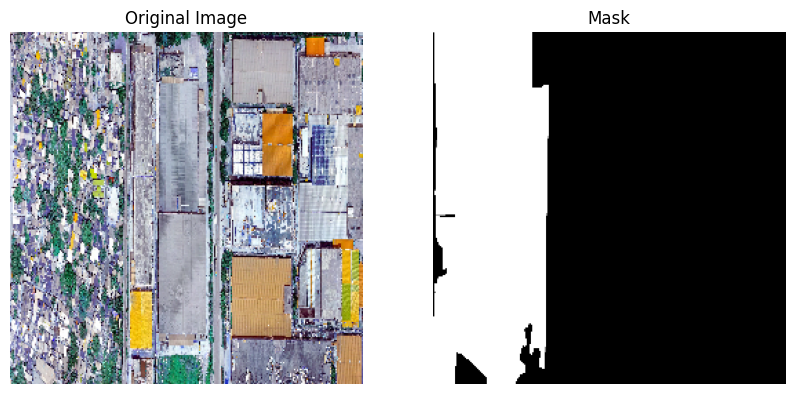

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_random_sample(X, y):
    idx = random.randint(0, len(X) - 1)

    image = X[idx]
    mask = y[idx]

    # Plot image and mask side by side
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)  # Image is already normalized
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")  # Mask is grayscale
    plt.title("Mask")
    plt.axis("off")

    plt.show()


plot_random_sample(X_train, y_train)


# **3.1 U-Net model for training to classify slum vs. non-slum areas (256 x 256)**

In [ ]:
from tensorflow.keras import layers, models

# Define the U-Net model
def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder (Downsampling Path)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    # Decoder (Upsampling Path)
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)  # Output layer with sigmoid for binary segmentation

    model = models.Model(inputs=[inputs], outputs=[outputs])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Initialize the model
model = unet_model()
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 256, 256, 32)   │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 256, 256, 32)   │          9,248 │ conv2d_38[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 128, 128, 32)   │              0 │ conv2d_39[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_40[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 64, 64, 64)     │              0 │ conv2d_41[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_42[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 32, 32, 128)    │              0 │ conv2d_43[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_44[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 16, 16, 256)    │              0 │ conv2d_45[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_46 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_47 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_46[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_8        │ (None, 32, 32, 256)    │        524,544 │ conv2d_47[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8        

 Total params: 7,760,097 (29.60 MB)

 Trainable params: 7,760,097 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=5
)


Epoch 1/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.7243 - loss: 0.1547 - val_accuracy: 0.8430 - val_loss: 0.2494
Epoch 2/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.7628 - loss: 0.2415 - val_accuracy: 0.8520 - val_loss: 0.1992
Epoch 3/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.8026 - loss: 0.2412 - val_accuracy: 0.8520 - val_loss: 0.2266
Epoch 4/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.7463 - loss: 0.2908 - val_accuracy: 0.8520 - val_loss: 0.2748
Epoch 5/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.7628 - loss: 0.2969 - val_accuracy: 0.8520 - val_loss: 0.2549
Epoch 6/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.7729 - loss: 0.2859 - val_accuracy: 0.8520 - val_loss: 0.2434
Epoch 7/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.7508 - loss: 0.2826 - val_accuracy: 0.8520 - val_loss: 0.2304
Epoch 8/300
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.7873 - loss: 0.2622 - val_accuracy: 0.8520 - v

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8225 - loss: 0.3594
Validation Loss: 0.3594399392604828
Validation Accuracy: 0.8224919438362122


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


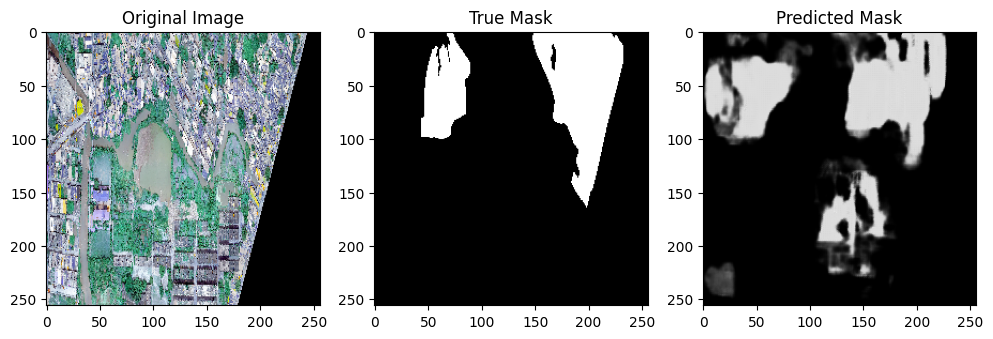

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


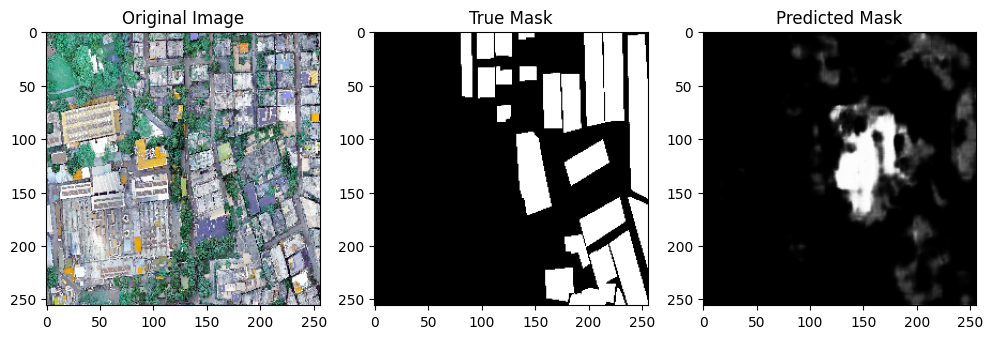

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


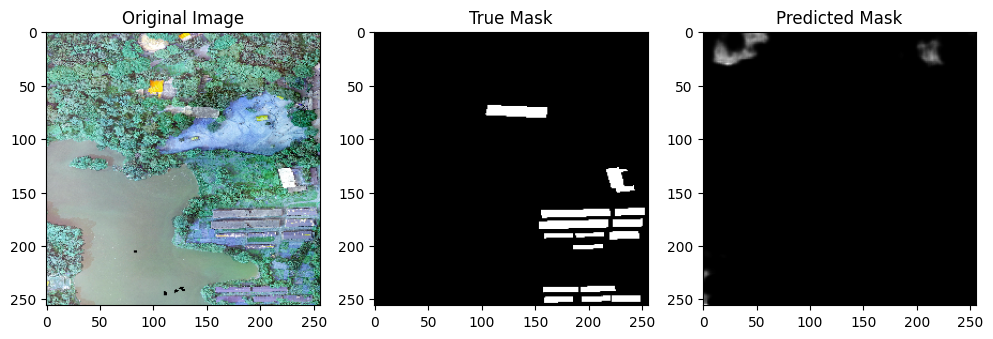

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


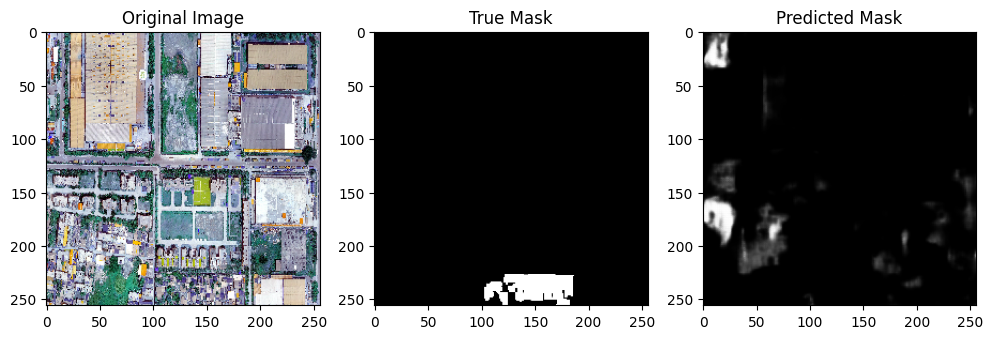

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


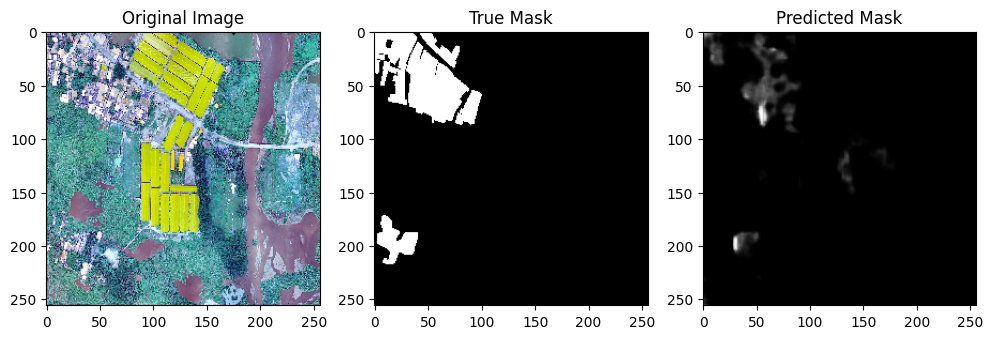

In [ ]:
# Visualize predictions
def visualize_predictions(model, image_paths, mask_paths, num_samples=5):
    for i in range(num_samples):
        image = cv2.imread(image_paths[i])
        mask = cv2.imread(mask_paths[i], cv2.IMREAD_GRAYSCALE)

        # Preprocess image and mask
        image, mask = preprocess_image_mask(image_paths[i], mask_paths[i])

        # Predict using the model
        pred_mask = model.predict(np.expand_dims(image, axis=0))

        # Original image, mask, and predicted mask
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Original Image")

        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("True Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[0], cmap='gray')
        plt.title("Predicted Mask")

        plt.show()

# Visualize predictions for 5 random samples
visualize_predictions(model, image_paths_val, mask_paths_val, num_samples=5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


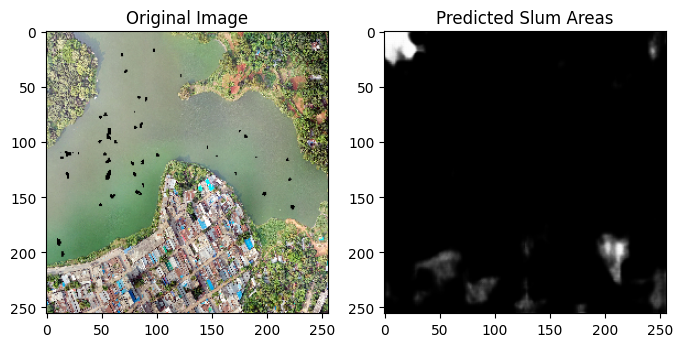

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


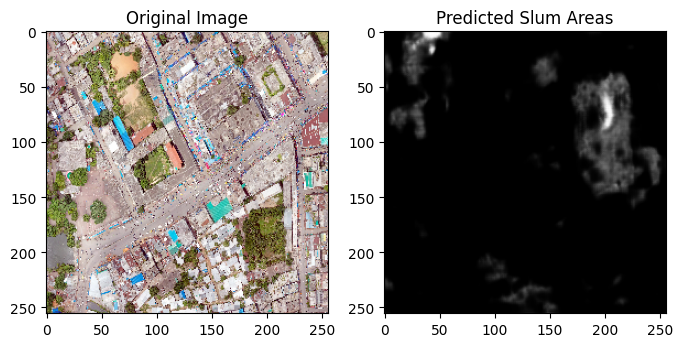

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


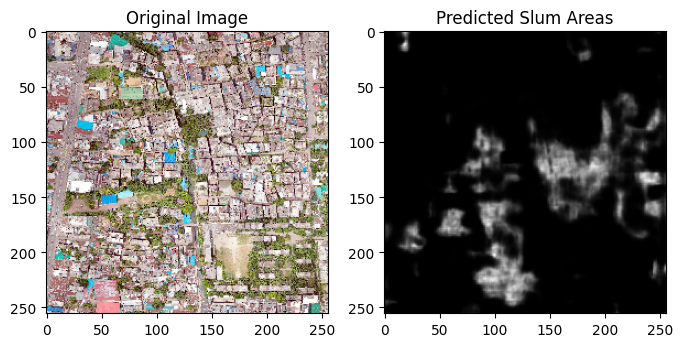

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob


def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, (256, 256))  # Resize to match model input
    image = image / 255.0  # Normalize
    return image


def predict_no_mask(model, image_paths):
    for img_path in image_paths:
        image = preprocess_image(img_path)

        # Predict slum areas
        pred_mask = model.predict(np.expand_dims(image, axis=0))[0]

        # Display results
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Original Image")

        plt.subplot(1, 2, 2)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Predicted Slum Areas")

        plt.show()

#  images in /No Mask/ directory
image_paths_nomask = glob.glob("/content/dataset/No Mask/*.jpg")

# Predict and visualize
predict_no_mask(model, image_paths_nomask)


# **3.2 U-Net model for training to classify slum vs. non-slum areas (512 x 512)**

In [31]:
from tensorflow.keras import layers, models

def unet_model(input_size=(512, 512, 3)):
    inputs = layers.Input(input_size)

    # Encoder (Downsampling Path)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    # Decoder (Upsampling Path)
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize the model
model = unet_model()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 512, 512, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 512, 512, 32)   │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 512, 512, 32)   │          9,248 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 256, 256, 32)   │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 256, 256, 64)   │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 128, 128, 64)   │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 64, 64, 128)    │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 32, 32, 256)    │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 64, 64, 256)    │        524,544 │ conv2d_28[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4        

 Total params: 7,760,097 (29.60 MB)

 Trainable params: 7,760,097 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
def preprocess_image_mask(image_path, mask_path, img_size=(512, 512)):

    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)


    image = cv2.resize(image, img_size)
    mask = cv2.resize(mask, img_size)


    image = image / 255.0
    mask = mask / 255.0

    return image, mask


def preprocess_dataset(image_paths, mask_paths, img_size=(512, 512)):
    images = []
    masks = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        image, mask = preprocess_image_mask(img_path, mask_path, img_size)
        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)


X_train, y_train = preprocess_dataset(image_paths_train, mask_paths_train)
X_val, y_val = preprocess_dataset(image_paths_val, mask_paths_val)


print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Training data mask shape: {y_train.shape}")
print(f"Validation data mask shape: {y_val.shape}")


Training data shape: (24, 512, 512, 3)
Validation data shape: (6, 512, 512, 3)
Training data mask shape: (24, 512, 512)
Validation data mask shape: (6, 512, 512)


In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=6
)


Epoch 1/300


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(6, 512, 512, 3))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 72s 7s/step - accuracy: 0.7765 - loss: 0.5556 - val_accuracy: 0.8522 - val_loss: 0.2744
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - accuracy: 0.7286 - loss: 0.3081 - val_accuracy: 0.8522 - val_loss: 0.2694
Epoch 3/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - accuracy: 0.7415 - loss: 0.2963 - val_accuracy: 0.8522 - val_loss: 0.2671
Epoch 4/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 510ms/step - accuracy: 0.7384 - loss: 0.2975 - val_accuracy: 0.8522 - val_loss: 0.2659
Epoch 5/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - accuracy: 0.7724 - loss: 0.2759 - val_accuracy: 0.8522 - val_loss: 0.2558
Epoch 6/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 452ms/step - accuracy: 0.7735 - loss: 0.2856 - val_accuracy: 0.8522 - val_loss: 0.2509
Epoch 7/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 447ms/step - accuracy: 0.7392 - loss: 0.2899 - val_accuracy: 0.8522 - val_loss: 0.2421
Epoch 8/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 454ms/step - accuracy: 0.7782 - loss: 0.2653 - val_accuracy: 0.8522 - val_loss: 0.247

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 512, 512, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


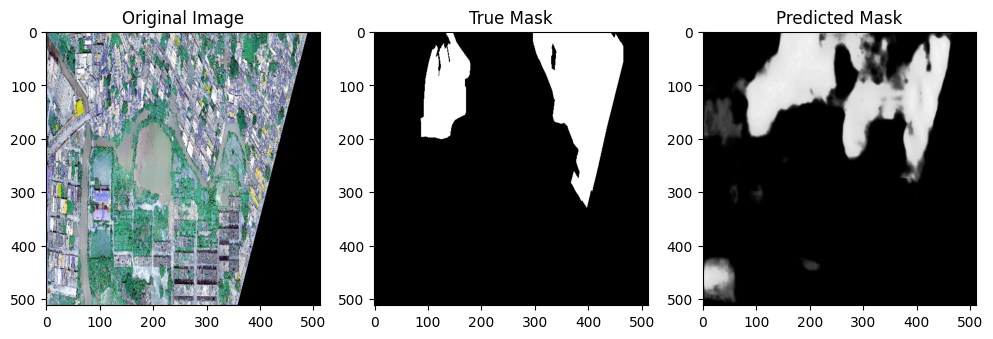

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


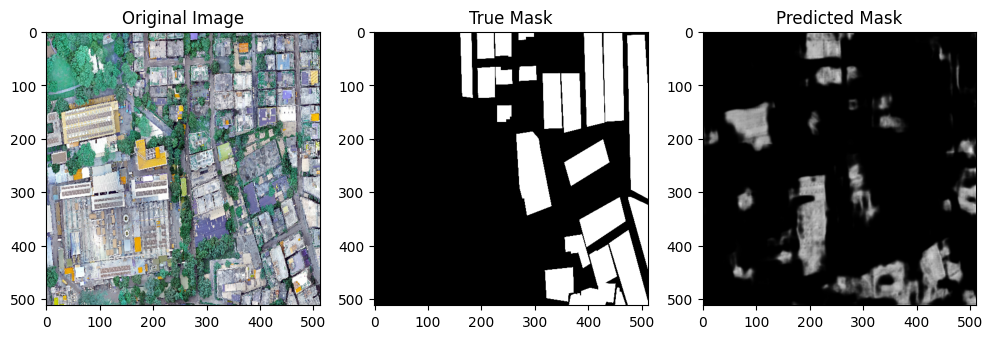

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


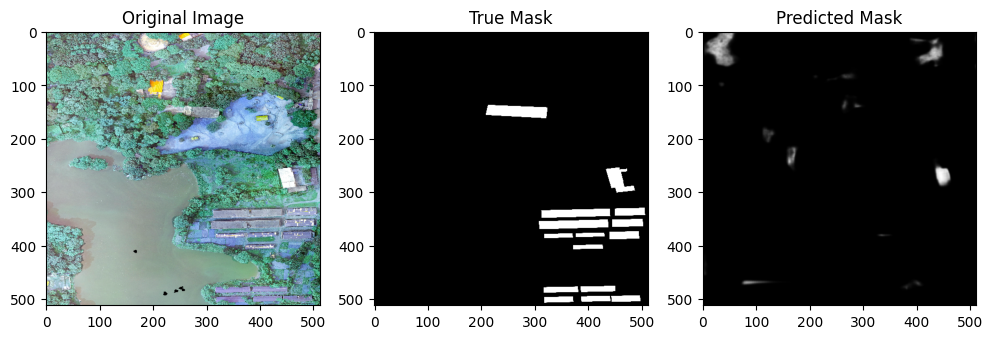

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


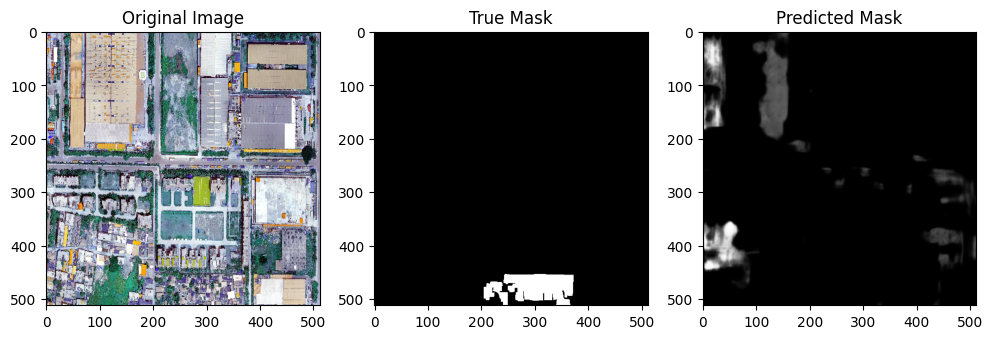

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


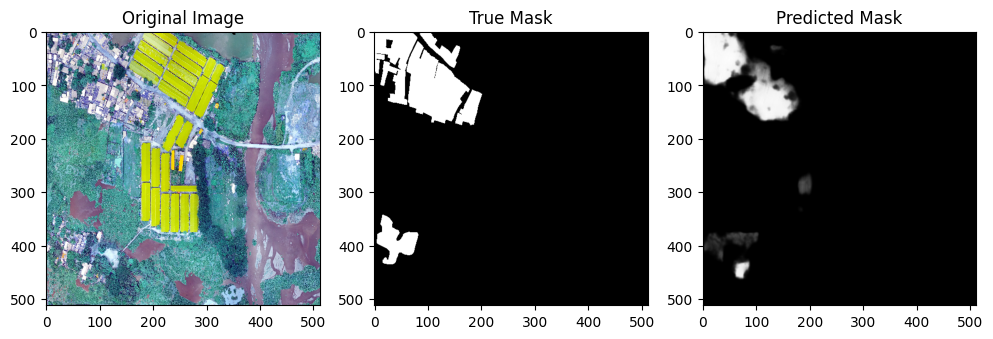

In [ ]:

def visualize_predictions(model, image_paths, mask_paths, num_samples=5):
    for i in range(num_samples):
        image = cv2.imread(image_paths[i])
        mask = cv2.imread(mask_paths[i], cv2.IMREAD_GRAYSCALE)


        image, mask = preprocess_image_mask(image_paths[i], mask_paths[i])


        pred_mask = model.predict(np.expand_dims(image, axis=0))


        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Original Image")

        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("True Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[0], cmap='gray')
        plt.title("Predicted Mask")

        plt.show()

visualize_predictions(model, image_paths_val, mask_paths_val, num_samples=5)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, None, None, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


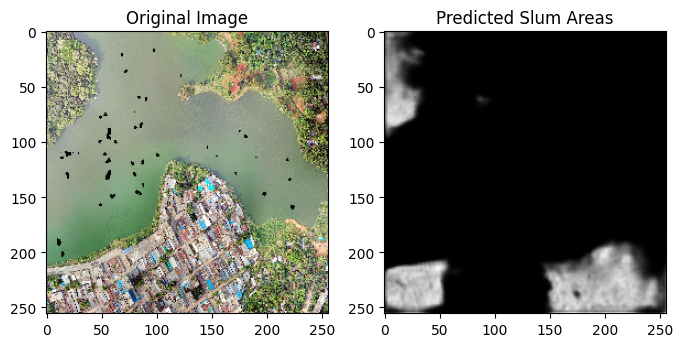

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


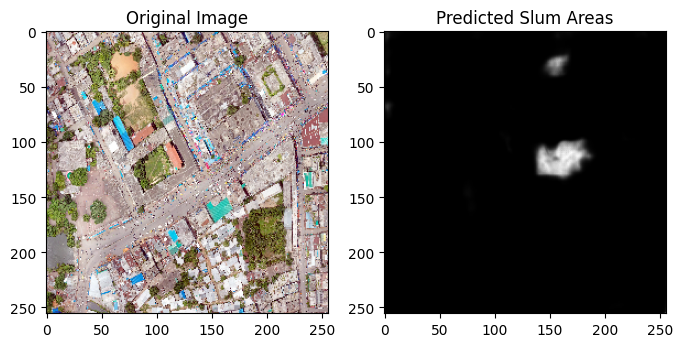

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


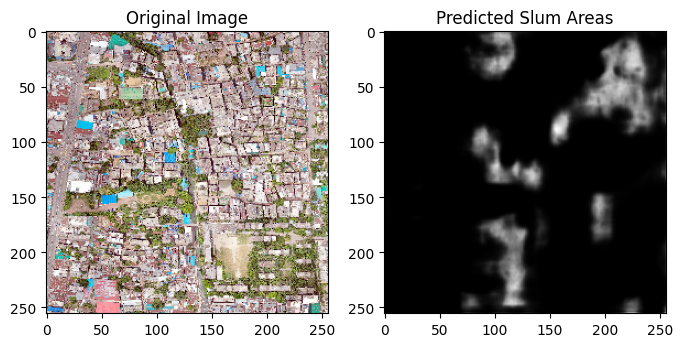

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob


def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, (256, 256))  # Resize to match model input
    image = image / 255.0  # Normalize
    return image


def predict_no_mask(model, image_paths):
    for img_path in image_paths:
        image = preprocess_image(img_path)


        pred_mask = model.predict(np.expand_dims(image, axis=0))[0]


        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Original Image")

        plt.subplot(1, 2, 2)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Predicted Slum Areas")

        plt.show()


image_paths_nomask = glob.glob("/content/dataset/No Mask/*.jpg")

# Predict and visualize
predict_no_mask(model, image_paths_nomask)


# **3.3 U-Net model for training to classify slum vs. non-slum areas (512 x 512)**

In [36]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=6
)


Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 72s 7s/step - accuracy: 0.7745 - loss: 0.2545 - val_accuracy: 0.8522 - val_loss: 0.2023
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 480ms/step - accuracy: 0.7708 - loss: 0.2277 - val_accuracy: 0.8522 - val_loss: 0.1962
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 473ms/step - accuracy: 0.7739 - loss: 0.2142 - val_accuracy: 0.8522 - val_loss: 0.1952
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 467ms/step - accuracy: 0.7634 - loss: 0.2221 - val_accuracy: 0.8522 - val_loss: 0.1973
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 470ms/step - accuracy: 0.7830 - loss: 0.2166 - val_accuracy: 0.8522 - val_loss: 0.2072
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 479ms/step - accuracy: 0.7806 - loss: 0.2180 - val_accuracy: 0.8522 - val_loss: 0.2035
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 471ms/step - accuracy: 0.7511 - loss: 0.2106 - val_accuracy: 0.8522 - val_loss: 0.1970
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 471ms/step - accuracy: 0.7876 - loss: 0.2226 - val_accuracy: 0.8522 - va

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


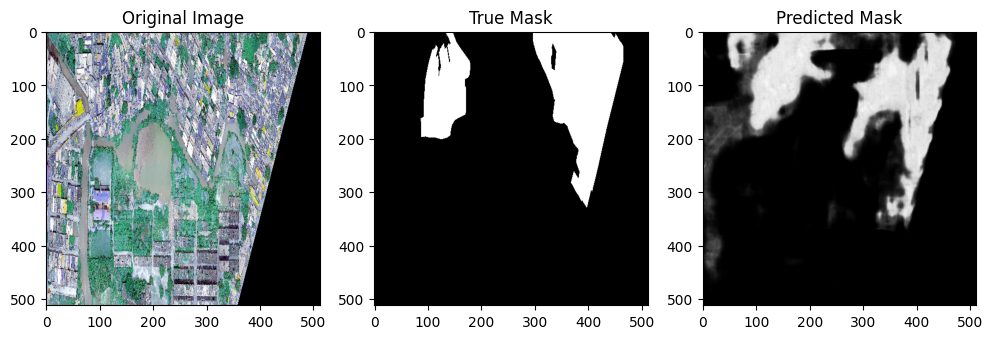

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


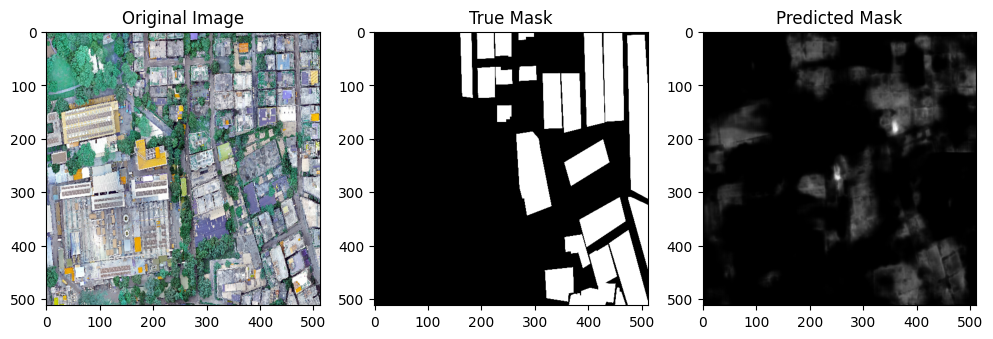

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


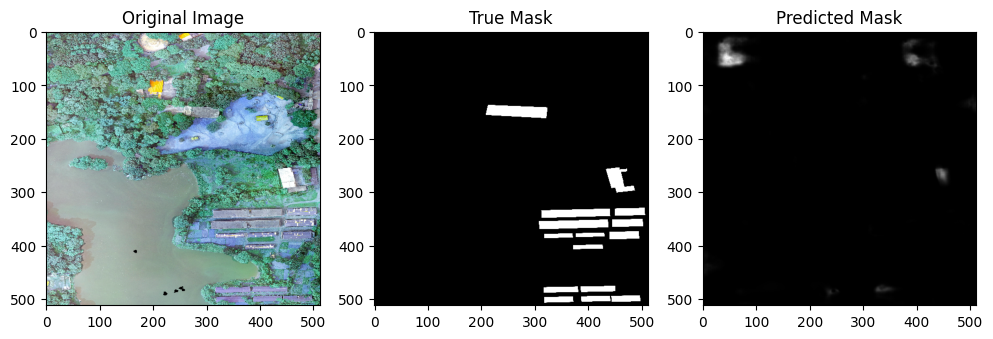

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


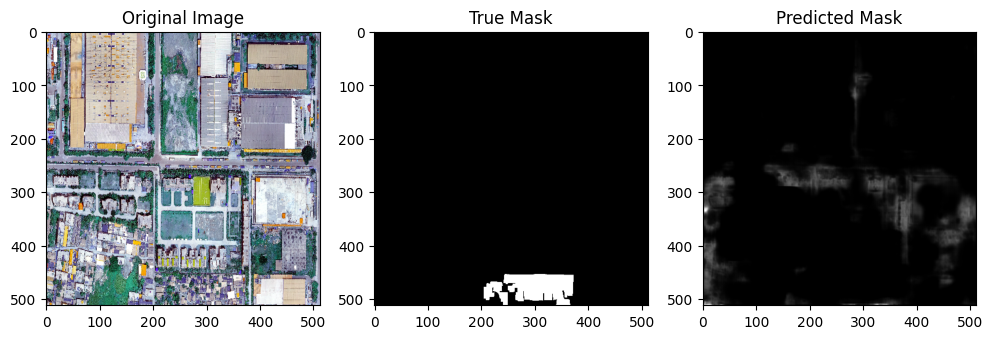

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


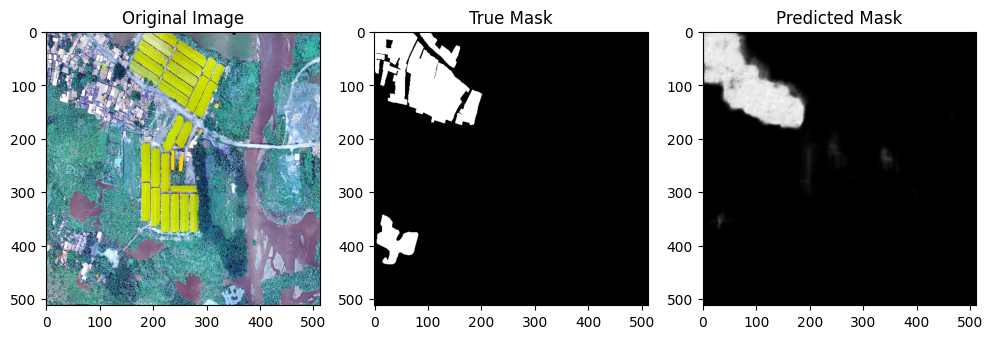

In [37]:

def visualize_predictions(model, image_paths, mask_paths, num_samples=5):
    for i in range(num_samples):
        image = cv2.imread(image_paths[i])
        mask = cv2.imread(mask_paths[i], cv2.IMREAD_GRAYSCALE)

        # Preprocess image and mask
        image, mask = preprocess_image_mask(image_paths[i], mask_paths[i])

        # Predict using the model
        pred_mask = model.predict(np.expand_dims(image, axis=0))

        # Display original image, mask, and predicted mask
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Original Image")

        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("True Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[0], cmap='gray')
        plt.title("Predicted Mask")

        plt.show()

# Visualize predictions for 5 random samples
visualize_predictions(model, image_paths_val, mask_paths_val, num_samples=5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


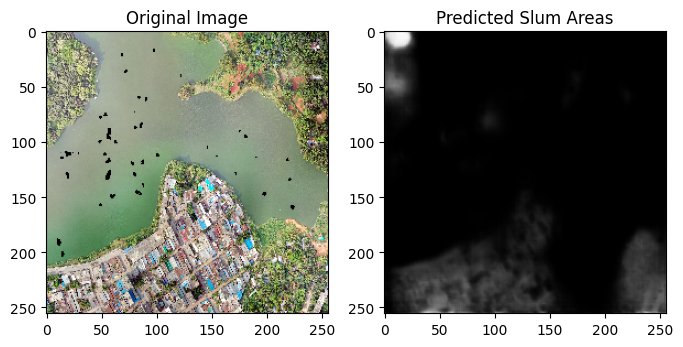

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


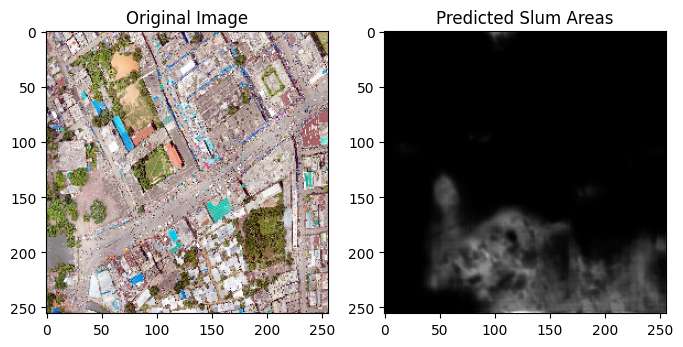

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


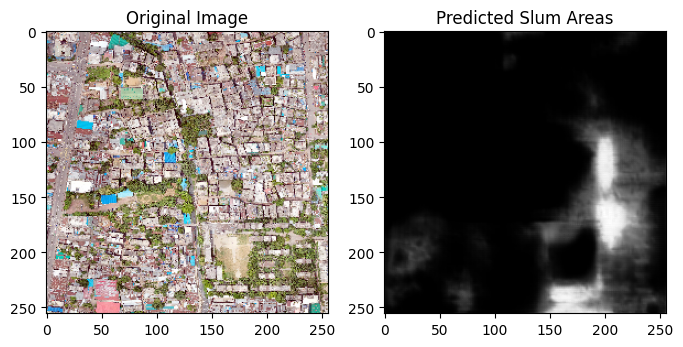

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob


def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))
    image = image / 255.0
    return image


def predict_no_mask(model, image_paths):
    for img_path in image_paths:
        image = preprocess_image(img_path)


        pred_mask = model.predict(np.expand_dims(image, axis=0))[0]

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Original Image")

        plt.subplot(1, 2, 2)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Predicted Slum Areas")

        plt.show()


image_paths_nomask = glob.glob("/content/dataset/No Mask/*.jpg")


predict_no_mask(model, image_paths_nomask)


# **4. Graphs**

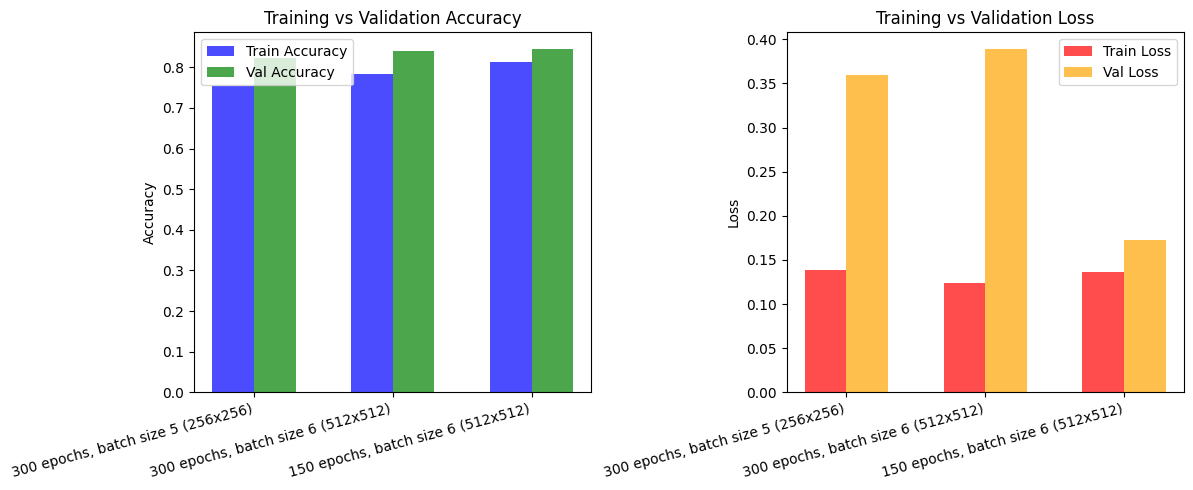

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model configurations
models = [
    "300 epochs, batch size 5 (256x256)",
    "300 epochs, batch size 6 (512x512)",
    "150 epochs, batch size 6 (512x512)"
]

# Accuracy and loss values
train_accuracy = [0.7537, 0.7837, 0.8123]
val_accuracy = [0.8225, 0.8390, 0.8437]
train_loss = [0.1388, 0.1236, 0.1368]
val_loss = [0.3594, 0.3885, 0.1729]

x = np.arange(len(models))  # Label locations
width = 0.3  # Width of the bars

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot Accuracy
ax[0].bar(x - width/2, train_accuracy, width, label='Train Accuracy', color='blue', alpha=0.7)
ax[0].bar(x + width/2, val_accuracy, width, label='Val Accuracy', color='green', alpha=0.7)
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training vs Validation Accuracy')
ax[0].set_xticks(x)
ax[0].set_xticklabels(models, rotation=15, ha='right')
ax[0].legend()

# Plot Loss
ax[1].bar(x - width/2, train_loss, width, label='Train Loss', color='red', alpha=0.7)
ax[1].bar(x + width/2, val_loss, width, label='Val Loss', color='orange', alpha=0.7)
ax[1].set_ylabel('Loss')
ax[1].set_title('Training vs Validation Loss')
ax[1].set_xticks(x)
ax[1].set_xticklabels(models, rotation=15, ha='right')
ax[1].legend()

plt.tight_layout()
plt.show()